# Redes MLP

Melhores resultados: 

|      | MLP |
|------|------------------|
| RMSE | 35724.18         |
| MAE  | 23680.35         |
| MAPE | 0.30             |

Config:

4 camadas com ativação relu e units (256, 128, 64, 32) e minmax

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from scipy.stats import pearsonr
from collections import Counter

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.random import set_seed

sns.set_palette("Paired")

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

from keras.layers import BatchNormalization

# Constantes e funções

In [3]:
PATH="https://raw.githubusercontent.com/LeiteJu/TCC/main/dados/input/"

SIGLAS = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
  'DF', 'ES', 'GO', 'MA',
  'MG', 'MS', 'MT', 'PA', 'PB',
  'PE', 'PI', 'PR', 'RJ',
  'RN', 'RO', 'RR', 'RS',
  'SC', 'SE', 'SP', 'TO']

LABELS=["subestima: -90%", "subestima entre -90% e 60%", "subestima entre -60% e -30%",
        "subestima entre -30% e 10%", "entre -10% e 10%", "superestima entre 10% e 30%", 
        "superestima entre 30% e 60%", "superestima entre 60% e 90%", "superestima mais de 90%"]

In [4]:
# calcula metricas de regressao
def score_regression_metrics(y_test, y_test_pred):

    RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
    R2 = r2_score(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "neg_root_mean_squared_error": RMSE,
        "neg_mean_absolute_error": MAE,
        "neg_mean_absolute_percentage_error": MAPE,
    }

    return scores

def show_scores (scores):

    print ("Scores obtidos:")

    print (f"RMSE: {scores['neg_root_mean_squared_error']}")
    print (f"MAE: {scores['neg_mean_absolute_error']}")
    print (f"MAPE: {scores['neg_mean_absolute_percentage_error']}")

In [5]:
def categorize(x):
    if x < - 0.9:
        return LABELS[0]
    elif x < - 0.6:
        return LABELS[1]
    elif x < - 0.3:
        return LABELS[2]
    elif x < - 0.1:
        return LABELS[3]
    elif x < 0.1:
        return LABELS[4]
    elif x < 0.3:
        return LABELS[5]
    elif x < 0.6:
        return LABELS[6]
    elif x < 0.9:
        return LABELS[7]
    else:
        return LABELS[8]

In [6]:
def show_delta (y_test, y_pred):
    
    data=(y_pred - y_test)/y_test

    error = pd.DataFrame(data, columns=['erro'])
    error['categoria']=error['erro'].apply(categorize)
    
    plt.figure(figsize=(28,6))

    g = sns.countplot(data=error, x='categoria', order=LABELS)
    
    plt.show()

In [7]:


def get_pred (y_train, y_pred):
    init = pd.to_datetime("072017", format='%m%Y')
    end = pd.to_datetime("122019", format='%m%Y')
    data = pd.date_range(start=init, end=end, freq='MS').date
    
    pred = pd.DataFrame(list(data) * 27, columns=['data']).sort_values('data')
    
    pred['estados'] = SIGLAS * 30
    
    pred['y_test'] =  y_test[len(y_test) % 27 :].values
    pred['y_pred'] = y_pred[len(y_pred) % 27 :]
    
    pred = pred.set_index('data')
    
    return pred

In [8]:
def show_pred (pred, states=SIGLAS):
    
    for state in states:
        
        fig, ax = plt.subplots()

        pred[pred['estados'] == state].plot(y="y_pred", ax=ax, figsize=(12,6), color="coral", title=f"Previsão x Dado Real: {state}", ylabel="Consumo")
        pred[pred['estados'] == state].plot(y="y_test", linestyle=' ', marker="o", ax=ax)

    plt.show()

# SEED

In [9]:
SEED = 41

def set_seeds (SEED=41):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

In [10]:
STATES = ['SP', 'RS','AL','DF']

# Dados

In [11]:
def load_data():
    
    df = pd.read_csv(f"{PATH}processado.csv")
    
    x  = df.copy()
    x = x.sort_values(["data", "estados"])
    x = x.drop(["consumo", 'data'], axis=1)

    y = df.copy().sort_values(["data", "estados"])[['estados', 'data', 'consumo']]
    
    # processo de one-hot
    x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

    y = y['consumo']
    
    return x,y

# Experimentos

## 1 camada de 16 neurônios

In [7]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=16, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

In [8]:
show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 2ms/step
Scores obtidos:
RMSE: 243855.39844645167
MAE: 145907.02718196597
MAPE: 0.934783225873137
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 200214.67739524876
MAE: 125018.53669454742
MAPE: 0.8547713216716768


## 1 camada de 32 neurônios

In [9]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 221671.7895034591
MAE: 132333.09632677742
MAPE: 0.8821725135615109
26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 170576.3018056728
MAE: 104801.33023623774
MAPE: 0.7490715999404003


## 2 camadas (64, 32)

In [10]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 2ms/step
Scores obtidos:
RMSE: 46081.09315398944
MAE: 28427.129880850403
MAPE: 0.36625061692052474
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 75830.59535459396
MAE: 45477.608256440355
MAPE: 0.5316910650192407


In [19]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 986us/step
Scores obtidos:
RMSE: 46638.52387772707
MAE: 27265.419387465892
MAPE: 0.3906691538883569
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 83891.59940503338
MAE: 53968.7495917951
MAPE: 0.7889138622799715


## 3 camadas (128, 64, 32)

### StandardScaler

In [11]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 31947.754090091094
MAE: 17602.572950413767
MAPE: 0.24823683800976182
26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 42261.20949484571
MAE: 28627.092664208925
MAPE: 0.4978281962250133


### MinMax Scaler

In [16]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 38022.79143504296
MAE: 20979.434833407744
MAPE: 0.31438016585949885
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 73288.59011951227
MAE: 41503.87268922522
MAPE: 0.49624956332055126


## 3 camadas (256, 128, 64)

### Standard Scaler

In [15]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 29190.314674853984
MAE: 16037.93752724236
MAPE: 0.21591592614328717
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 44757.04259393303
MAE: 30934.44711093372
MAPE: 0.6082110941391301


### MinMax Scaler

#### 100 epochs

In [17]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 33383.11175827079
MAE: 18321.270373631854
MAPE: 0.24850061302641335
26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 51670.28882242578
MAE: 31721.802826481256
MAPE: 0.46628544462808796


#### 200 epochs

In [25]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 29218.03497928721
MAE: 16281.666354033843
MAPE: 0.1930986188540174
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 39237.195428411374
MAE: 24710.17849011865
MAPE: 0.3561269422536886


#### 300 epochs

In [26]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=300, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 4ms/step
Scores obtidos:
RMSE: 27167.7962460437
MAE: 14868.129110760565
MAPE: 0.1856085018205519
26/26 [==============================] - 0s 4ms/step
Scores obtidos:
RMSE: 38497.330242540025
MAE: 24934.504427595035
MAPE: 0.29894757959468515


#### 400 epochs

In [27]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=400, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 26719.970337110975
MAE: 14512.683096699402
MAPE: 0.19326927691685447
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 41982.76033219207
MAE: 28351.057913580713
MAPE: 0.4400692429571572


## 4 camadas (256, 128, 64, 32)

#### 100 epochs

In [14]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 33527.73530063273
MAE: 17501.722512212484
MAPE: 0.1878275153380759
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 52495.27907264181
MAE: 32900.484561574216
MAPE: 0.4794580221388022


#### 100 epochs

In [18]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 33912.23778391012
MAE: 18018.86626214142
MAPE: 0.2184549097850674
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 36075.028292179486
MAE: 24397.63993538392
MAPE: 0.3950214330478227


#### 200 epochs

In [24]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 26840.052188467846
MAE: 14461.880787689634
MAPE: 0.18002862545399428
26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 35724.1888231112
MAE: 23680.35123186215
MAPE: 0.30510319243081785


In [ ]:
x,y = load_data()

DROP=['pib_pc',  'selic', 'idh_e', 'idh_l', 'nfsp', 'preco_ton', 'estoque']
x=x.drop(DROP, axis=1)

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 35732.45874471866
MAE: 20241.627538015633
MAPE: 0.23687227094651608
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 55034.661790168684
MAE: 33021.67671412107
MAPE: 0.36704863405761723


#### 300 epochs

In [21]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=300, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 26779.196313753888
MAE: 14494.05190789812
MAPE: 0.18822877258579404
26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 41166.860360902996
MAE: 28085.568436130216
MAPE: 0.42987587917173653


In [20]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=512, activation="relu")),
model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 4ms/step
Scores obtidos:
RMSE: 27672.907171698225
MAE: 14826.066428157465
MAPE: 0.1848244295884483
26/26 [==============================] - 0s 4ms/step
Scores obtidos:
RMSE: 37759.23364150197
MAE: 24989.988986217126
MAPE: 0.38621380423914514


In [22]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=512, activation="relu")),
model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=300, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 22816.804160045063
MAE: 11691.57109677503
MAPE: 0.10526383707673934
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 48382.2560821487
MAE: 32588.463328720147
MAPE: 0.4823878235997368


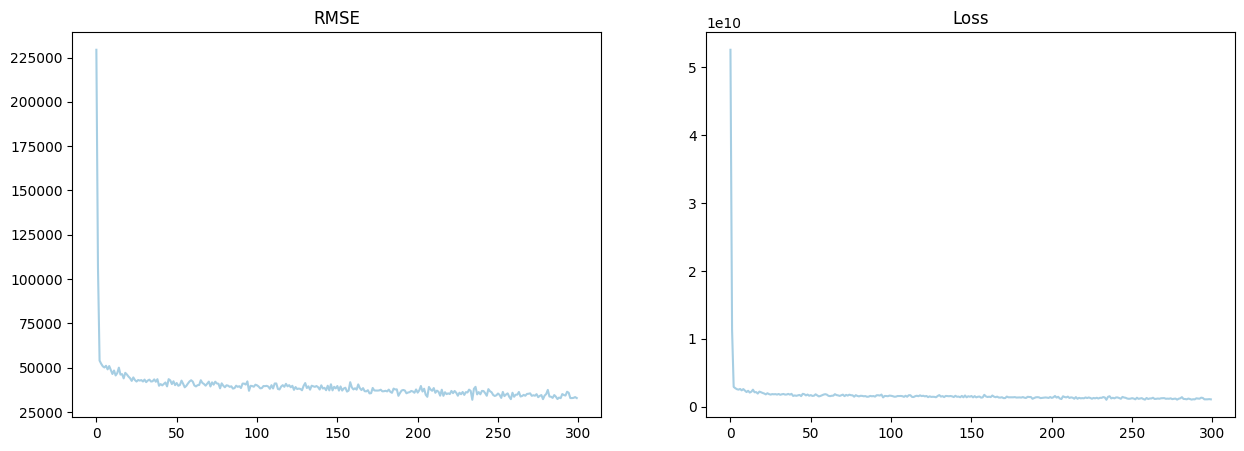

In [23]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [17]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=64, activation="swish")),
model.add(Dense(units=32, activation="swish")),
model.add(Dense(units=16, activation="swish")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Epoch 1/100
147/147 [==============================] - 1s 1ms/step - loss: 71577591808.0000 - RMSE: 267539.8750
Epoch 2/100
147/147 [==============================] - 0s 2ms/step - loss: 70821928960.0000 - RMSE: 266123.9062
Epoch 3/100
147/147 [==============================] - 0s 1ms/step - loss: 65813430272.0000 - RMSE: 256541.2812
Epoch 4/100
147/147 [==============================] - 0s 1ms/step - loss: 53766266880.0000 - RMSE: 231875.5469
Epoch 5/100
147/147 [==============================] - 0s 2ms/step - loss: 40661295104.0000 - RMSE: 201646.4531
Epoch 6/100
147/147 [==============================] - 0s 1ms/step - loss: 31565107200.0000 - RMSE: 177665.7188
Epoch 7/100
147/147 [==============================] - 0s 1ms/step - loss: 22431612928.0000 - RMSE: 149771.8750
Epoch 8/100
147/147 [==============================] - 0s 2ms/step - loss: 15119506432.0000 - RMSE: 122961.3984
Epoch 9/100
147/147 [==============================] - 0s 2ms/step - loss: 10190947328.0000 - RMSE: 1009

### Swish

In [18]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=64, activation="swish")),
model.add(Dense(units=64, activation="swish")),
model.add(Dense(units=64, activation="swish")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Epoch 1/100
147/147 [==============================] - 1s 1ms/step - loss: 71439515648.0000 - RMSE: 267281.7188
Epoch 2/100
147/147 [==============================] - 0s 1ms/step - loss: 66161598464.0000 - RMSE: 257218.9688
Epoch 3/100
147/147 [==============================] - 0s 1ms/step - loss: 45102243840.0000 - RMSE: 212372.8906
Epoch 4/100
147/147 [==============================] - 0s 1ms/step - loss: 28856999936.0000 - RMSE: 169873.4844
Epoch 5/100
147/147 [==============================] - 0s 1ms/step - loss: 14253658112.0000 - RMSE: 119388.6875
Epoch 6/100
147/147 [==============================] - 0s 1ms/step - loss: 6958274560.0000 - RMSE: 83416.2734
Epoch 7/100
147/147 [==============================] - 0s 1ms/step - loss: 4117347840.0000 - RMSE: 64166.5625
Epoch 8/100
147/147 [==============================] - 0s 1ms/step - loss: 3077021184.0000 - RMSE: 55470.9023
Epoch 9/100
147/147 [==============================] - 0s 1ms/step - loss: 2673903616.0000 - RMSE: 51709.8008


In [19]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="swish")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Epoch 1/100
147/147 [==============================] - 1s 2ms/step - loss: 70672498688.0000 - RMSE: 265843.0000
Epoch 2/100
147/147 [==============================] - 0s 2ms/step - loss: 48438218752.0000 - RMSE: 220086.8438
Epoch 3/100
147/147 [==============================] - 0s 2ms/step - loss: 31399561216.0000 - RMSE: 177199.2188
Epoch 4/100
147/147 [==============================] - 0s 2ms/step - loss: 24982511616.0000 - RMSE: 158058.5625
Epoch 5/100
147/147 [==============================] - 0s 2ms/step - loss: 16915574784.0000 - RMSE: 130059.8906
Epoch 6/100
147/147 [==============================] - 0s 2ms/step - loss: 9074806784.0000 - RMSE: 95261.7812
Epoch 7/100
147/147 [==============================] - 0s 2ms/step - loss: 4457403392.0000 - RMSE: 66763.7891
Epoch 8/100
147/147 [==============================] - 0s 2ms/step - loss: 3151446016.0000 - RMSE: 56137.7422
Epoch 9/100
147/147 [==============================] - 0s 2ms/step - loss: 2636336640.0000 - RMSE: 51345.2695


# Gráficos

In [20]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 27456.295136256937
MAE: 15191.316723967593
MAPE: 0.1749188184082079
26/26 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 38546.13797681909
MAE: 24716.07923617934
MAPE: 0.33326037254709806


In [22]:
pred = get_pred(y_test, y_pred)

In [52]:
def show_graphs (pred, reg):
    
    plt.figure(figsize=(14,6))
    
    
    plt.title("Visão regional")
    
    for state in reg:
        
        sns.scatterplot(pred[pred['estados'] == state]['y_test'], label=f"Dado real de {state}")
        sns.lineplot(pred[pred['estados'] == state]['y_pred'], label=f"Previsão e {state}")
        
    plt.ylabel="Consumo"
        
    plt.show()

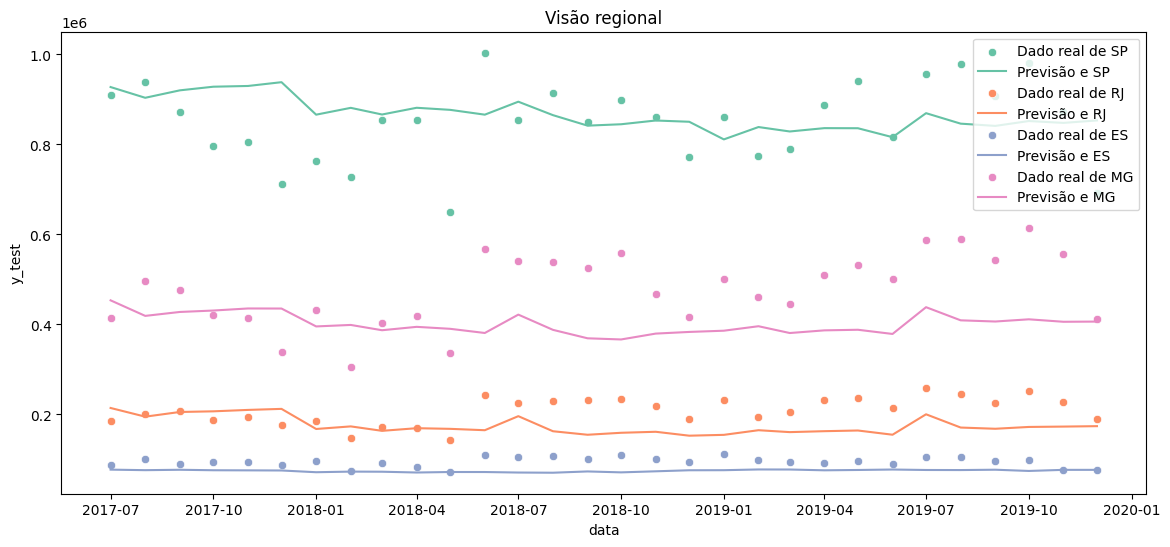

In [54]:
SUDESTE = ['SP', 'RJ', 'ES', 'MG']

show_graphs(pred, SUDESTE)

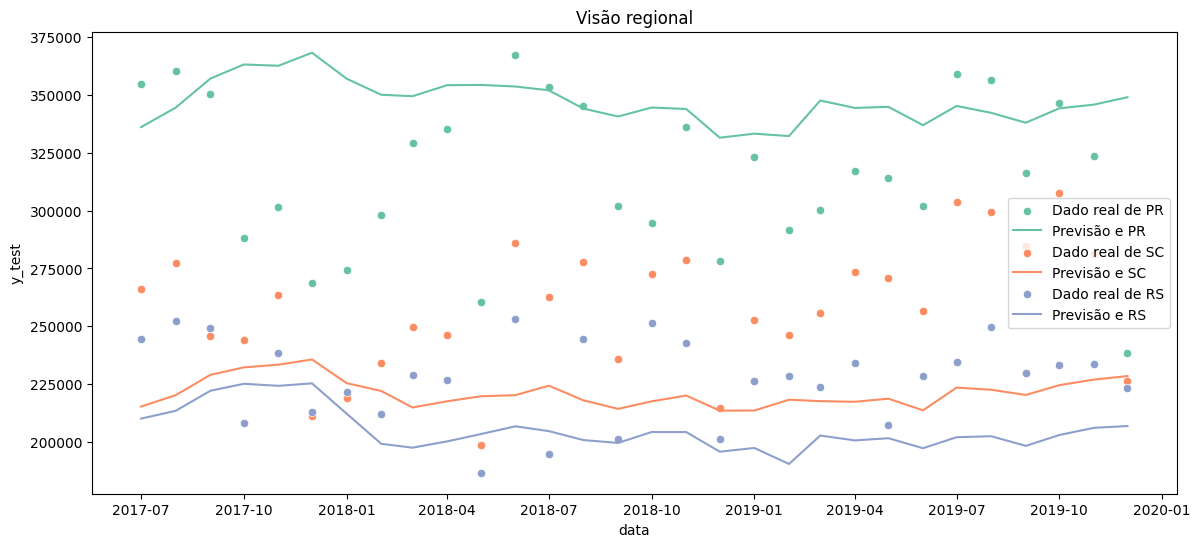

In [56]:
SUL = ['PR', 'SC', 'RS']

sns.set_palette("Set2")

show_graphs(pred, SUL)

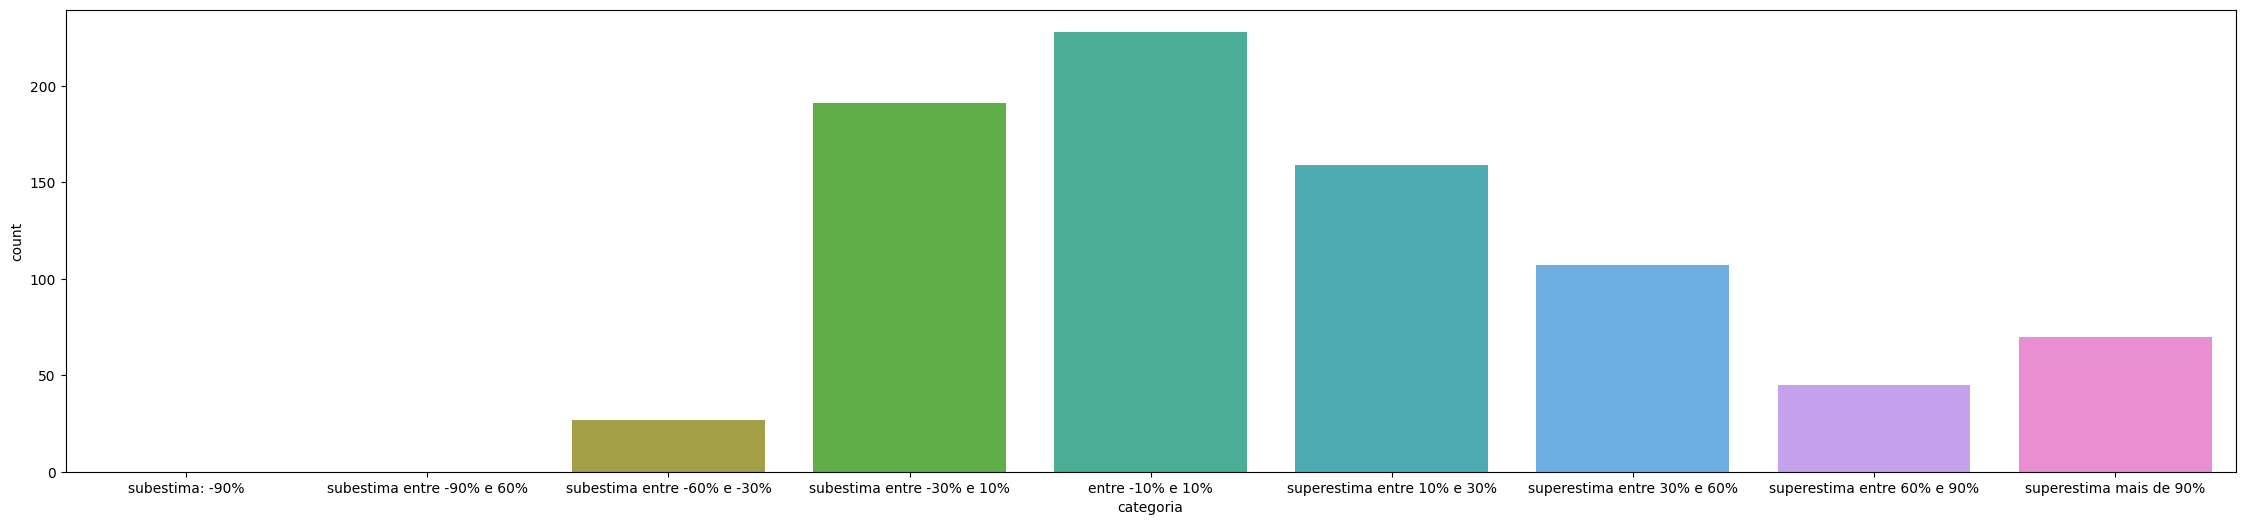

In [57]:
show_delta(np.array(y_test), y_pred.flatten())